In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

C:\Users\User\AppData\Local\Temp\ipykernel_15672\1652790876.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare(engine, reflect=True)


In [8]:
# View all of the classes that automap found
print(base.classes.keys())

['measurement', 'station']


In [10]:
# Save references to each table
station = base.classes.station
measurement = base.classes.measurement

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).first()
print(most_recent_date)

('2017-08-23',)


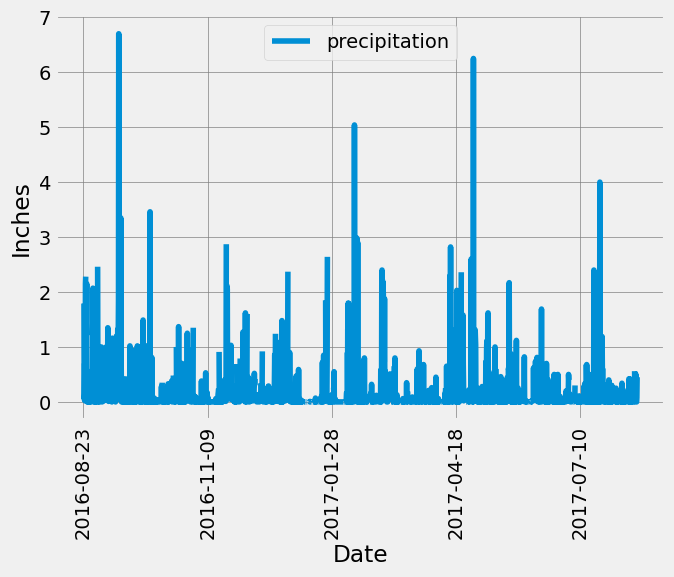

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(measurement.date)).scalar()

# Calculate the date 12 months from the last date in data set.
last_12_months = (pd.to_datetime(most_recent_date) - pd.DateOffset(months=12)).date()

# Perform a query to retrieve the precipitation data
precipitation = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= last_12_months).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=["date", "precipitation"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by="date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.set_index("date").plot(figsize=(7, 5))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.grid(color="gray", linestyle="-", linewidth=0.5)
plt.show()

In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = pd.DataFrame(precipitation_df["precipitation"].describe())

# Print the result
summary_statistics

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).all()
print(total_stations)

[(9,)]


In [28]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    measurement.station,
    func.count(measurement.station).label("station_count")
).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

station_counts = [(station,count) for station,count in most_active_stations]
pprint(station_counts)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]


In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = "USC00519281"

temperature_stats = session.query(
    func.min(measurement.tobs).label("Lowest Temperature"),
    func.max(measurement.tobs).label("Highest Temperature"),
    func.avg(measurement.tobs).label("Average Temperature")
).filter(measurement.station == most_active_station_id).all()

# Print the result directly
print(temperature_stats)

[(54.0, 85.0, 71.66378066378067)]


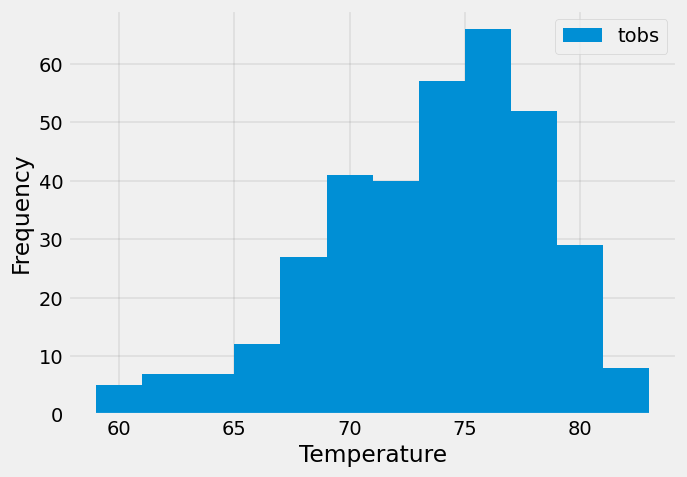

In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(measurement.date)).scalar()

# Calculate the date 12 months from the last date in data set.
last_12_months = str(pd.to_datetime(most_recent_date) - pd.DateOffset(months=12))

# Perform a query to retrieve the temperature observation data(tobs)
tobs = session.query(measurement.date, measurement.tobs).filter(
    measurement.station == most_active_station_id,
    measurement.date >= last_12_months).all()

# Save the results as a Pandas DataFrame
tobs_df = pd.DataFrame(tobs, columns=["date", "temperature"])

# Plot the data as a histogram
tobs_df["temperature"].plot(kind="hist", bins=12, figsize=(7, 5))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.grid(color="gray", linestyle="-", linewidth=0.2)
plt.show()

# Close Session

In [ ]:
# Close Session
session.close()